![Curso de Visión Artificial](imagenes/encabezado.png)




# Procesamiento Básico de Imágenes II

Después de la captura de las imágenes, el siguiente paso consiste en preprocesar la imagen a fin de eliminar el ruido en la misma y/o resaltar los objetos de interés. Como se mencionó en la clase, existen diferentes tipos de operaciones. En esta práctica nos centraremos en las operaciones puntuales, específicamente en las operaciones sobre el histograma.




## El Histograma

En la práctica pasada utilizamos un código básico para mostrar una imagen y su histograma, tanto para imágenes en niveles de gris como para imágenes a color.

Dado en los proyectos de visión artificial es muy común visualizar usar el histograma de una imagen para determinar que tipo de preprocesamiento aplicar a la misma, es necesario crear o utilizar una función que nos permita hacerlo. Lamentablemente, `skimage` no posee dicha función, aunque esta si se encuentra implementada en un paquete creado para los tutoriales de `skimage`. Dicho paquete, llamado `skdemo`, se anexa a los archivos de esta práctica, por lo que empezaremos a utilizarlo.


In [6]:
# Siempre que usemos matplotlib en Jupyter es necesario poner esta línea antes de cualquier otra
%matplotlib inline

# Importamos las bibliotecas necesarias y les asigamos un alias
import skimage                           # Biblioteca para la manipulación de imágenes
import numpy as np                       # Biblioteca para la manipulación de matrices

# Importamos algunos paquetes específicos
from matplotlib import pyplot as plt     # Biblioteca para crear graficas y mostrar las imágenes en pantalla
from skimage import data                 # Paquete con imágenes de prueba
from skimage import io                   # Paquete para lectura/escritura de imágenes

from skimage import color                # Paquete con las operaciones de transformaciones entre espacios de color
from skimage import exposure             # Paquete con las funciones para calcular y alterar el histograma

####################

import skdemo                            # Paquete ESPECIAL ADJUNTO con algunas funciones extra de visualización

Entonces, ahora usemos skdemo para mostrar el histograma de una imagen:

(<matplotlib.axes._subplots.AxesSubplot at 0x24090766080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x240907ea780>)

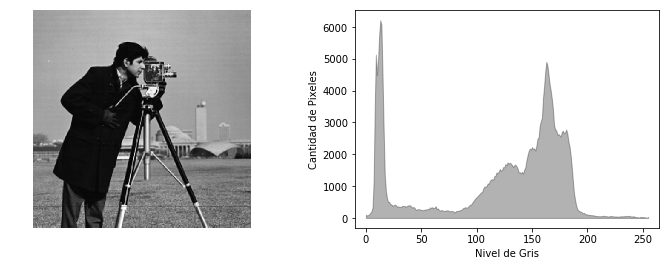

In [7]:
# Cargamos la imagen
img = data.camera()

# Calcula y muestra el histograma de la imagen
skdemo.imshow_with_histogram(img)

Ahora sí, iniciemos con las operaciones sobre el histograma.

## Expansión del Histograma

Como vimos en clase, mejorar el contraste de una imagen nos permite identificar más fácilmente los objetos de interés en la imagen, además que facilita el proceso de su segmentación y la extracción de sus características, esto bien sea a ojo o utilizando diferentes tipos de algoritmos.

Eche un vistazo a la imagen del fotógrafo y a su histograma:
* Observe detenidamente el histograma: dado que la imagen es de tipo `uint8`, los valores de niveles de intensidad van de 0 a 255. 
* Advierta que hay algunos pocos píxeles hacia el valor 255 y otros pocos por debajo del 10. Esto nos indica que la imagen no tiene una distribución adecuada de los píxeles cercanos al blanco.

En este caso, podemos aplicar una **Expansión del Histograma**:

![alt text](imagenes/expansion.png)

Para hacer esto podemos hacer uso de la función `rescale_intensity` de `Scikit-Image`:

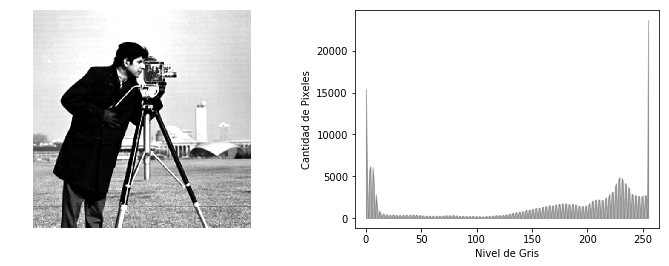

In [8]:
# Los puntos que se están moviendo son m=10 y M=180, de acuerdo a la ecuación presentada en las diapositivas
img_contraste = exposure.rescale_intensity(img, in_range=(10, 180))

# Mostramos el histograma usando la biblioteca skdemo
skdemo.imshow_with_histogram(img_contraste);


Ahora, el contraste en la imagen es visiblemente más alto, y esto se puede observar en el histograma. El pico tan alto a   la derecha se genera porque todos los píxeles mayores a 180 (en la imagen original) se agruparon en el valor 255. Es decir, hay muchos píxeles que quedaron **saturados**.

Esta función también permite definir cuál es el intervalo de los niveles de gris de salida, por ejemplo, apliquemos una expansión definiendo, además, el intervalo de salida de los niveles de gris.


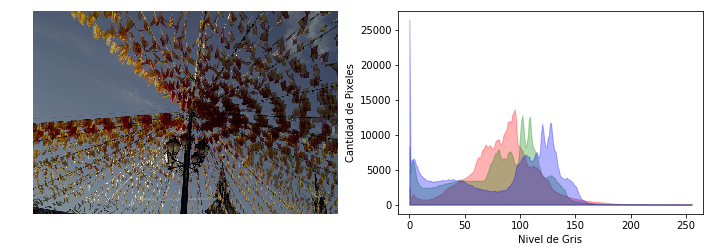

In [13]:
# En este caso apliquemos la expansión a la imagen 3 de la práctica
img3 = io.imread("imagenes/img3.jpg")

# Visualizamos la imagen y su histograma
skdemo.imshow_with_histogram(img3);


En el resultado vemos que los histogramas están concentrados en valores por debajo al nivel de gris 100, que es un nivel de gris oscuro, lo que hace que la imagen esté oscura. Apliquemos una expansión al histograma con valores de salida de los niveles de gris entre el 20 y el 220:


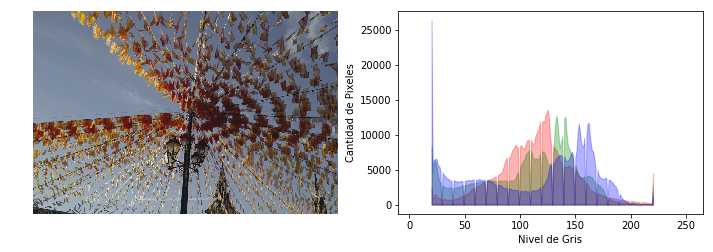

In [14]:
# Los puntos que se están moviendo son m=0 y M=180, de acuerdo a la ecuación presentada en las diapositivas
img3_contraste = exposure.rescale_intensity(img3, in_range=(0, 180), out_range=(20,220))

# Mostramos el histograma usando la biblioteca skdemo
skdemo.imshow_with_histogram(img3_contraste);

Note que el contraste de la imagen mejoró, pero no lo suficiente. Tratemos ahora haciendo una expansión completa del histograma, es decir, con un rango de salida del 0 al 255 (el cual no se especifica en la transformación).

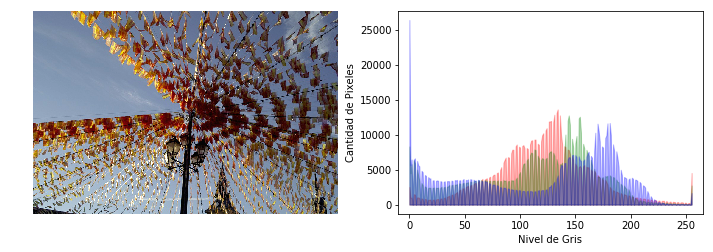

In [15]:
# Los puntos que se están moviendo son m=0 y M=180, de acuerdo a la ecuación presentada en las diapositivas
img3_contraste = exposure.rescale_intensity(img3, in_range=(0, 180))

# Mostramos el histograma usando la biblioteca skdemo
skdemo.imshow_with_histogram(img3_contraste);

En este caso particular, la aplicación de la expansión del histograma mejoró mucho con respecto a la imagen original.



## Ecualización del Histograma

Si bien, la expansión del histograma suele funcionar, hay funciones un poco más "inteligentes" que logran mejores resultados. Una de ellas es la **ecualización del histograma** la cual busca generar una imagen cuyo histograma tenga una **distribución uniforme** entre los valores de intensidad. 

Empecemos entonces viendo la función de distribución acumulada (CDF) de las intensidades de la imagen del fotógrafo:

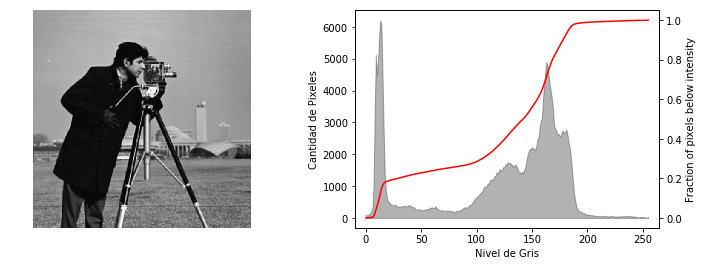

In [16]:
ax_image, ax_hist = skdemo.imshow_with_histogram(img)
skdemo.plot_cdf(img, ax=ax_hist.twinx())


La CDF muestra, para cada valor de intensidad, cual es la probabilidad cumulada de ese valor de intensidad.

Una forma de determinar el contraste en la imagen es observar que tan uniforme es la distribución de valores de intensidad. Note que la capa del fotógrafo contrasta marcadamente con el fondo, pero la distribución tan apretada de los píxeles en esa zona indica que los detalles de la capa están ocultos.

Para mejorar el contraste, se deben dispersar las intensidades que están estrechamente distribuidas y combinar estas con las intensidades cercanas que solo utilizan unos pocos píxeles.

Esta redistribución es exactamente lo que hace la **ecualización del histograma**. Y la CDF es importante porque una distribución perfectamente uniforme da una CDF que es una línea recta. 

Para ecualizar una imagen en `Skimage`, se usa el comando `equalize_hist` del paquete `exposure`:

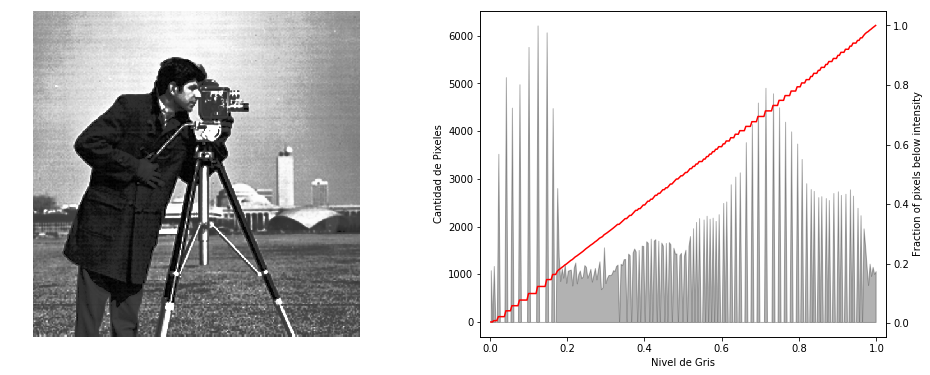

In [19]:
# Se ecualiza la imagen
img_ecualizada = exposure.equalize_hist(img)


# OJO Use esta instrucción para cambiar el tamaño de visualización de las imágenes de aquí en adelante!
plt.rcParams['figure.figsize'] = [8, 6]

# Se calcula y muestra el histograma y la CDF de la imagen ecualizada
ax_image, ax_hist = skdemo.imshow_with_histogram(img_ecualizada)
skdemo.plot_cdf(img_ecualizada, ax=ax_hist.twinx())

Note que los píxeles oscuros que describen el abrigo se han extendido, esto permite ver los detalles que antes no se veían. Además, note que la función de distribución acumulada es más pareja y se aproxima a una línea recta.

<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:#A43D39"><h3>**Nota:**</h3></span> Tenga presente que los niveles de intensidad cambiaron y ya no están en el rango <span style="color:blue; font-family:Courier new">[0, 255]</span>, sino en el rango <span style="color:blue; font-family:Courier new">[0.0, 1.0]</span>, lo que significa que el tipos de la imagen cambió.</div>

In [21]:
img_ecualizada.dtype

dtype('float64')

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
<span style="color:#4BACC6"><h3>**Para Tener en Cuenta:**</h3></span> Las funciones en <span style="color:blue; font-family:Courier new">scikit-image</span> normalmente funcionan con cualquier tipo de datos de  entrada, pero la salida puede cambiar dependiendo del algoritmo. Si bien <span style="color:blue; font-family:Courier new">uint8</span> es realmente eficiente en términos de almacenamiento, algunos cálculos que usan imágenes <span style="color:blue; font-family:Courier new">uint8</span> pueden ser problemáticos en ciertos casos.
<br/><br/>
Si necesita un tipo de datos específico, consulte las funciones de conversión de imágenes.</div>


## Ecualización Adaptativa del Histograma

Un problema de la ecualización del histograma es que esta tiende generar imágenes cuyo contraste es artificialmente alto. No obstante, la ecualización se puede mejorar solamente si se aplica localmente a ciertas partes de la imagen, en lugar de aplicarla a la imagen completa. Note que, en el ejemplo anterior, el contraste en la capa del fotógrafo es mucho mejor, pero el contraste en la hierba se reduce.

La **ecualización adaptativa del histograma con limitaciones de contraste (CLAHE)** aborda estos problemas. Los detalles de implementación no se presentan, pero ver el resultado es muy útil:

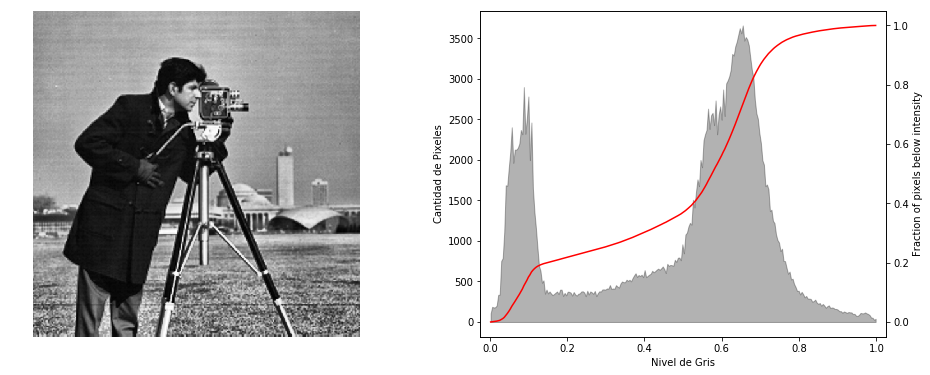

In [22]:
img_ecualizada = exposure.equalize_adapthist(img)

ax_image, ax_hist = skdemo.imshow_with_histogram(img_ecualizada)
skdemo.plot_cdf(img_ecualizada, ax=ax_hist.twinx())


En comparación con la ecualización de histograma simple, note que se mantiene contraste alto en la capa, pero el contraste en la hierba también se mejora, manteniendo el contraste del cielo. Esto hace que la imagen no se vea excesivamente mejorada.

De nuevo, tenga cuidado con el tipo de dato de salida, puesto que en este caso la imagen es de tipo <span style="color:blue; font-family:Courier new">uint16</span>.

Más información sobre la ecualización adaptativa se puede consultar en:

http://scikit-image.org/docs/dev/api/skimage.exposure.html 



# Entregable de la Práctica


### Ejercicio 1. Operaciones Entre Múltiples Imágenes

Las operaciones entre múltiples imágenes son comunes en la etapa de preprocesamiento. Una aplicación frecuente de este tipo de operaciones se presenta en el proceso de extracción del background (o fondo) de una imagen para segmentar los objetos de interés en la misma, por ejemplo, para extraer los objetos en movimiento de un video.

Siga los pasos a continuación para segmentar los objetos en movimiento en una vía rápida:

In [ ]:
# 1. Creee un vector de ceros de 100x240x320x3 (100 imagenes de 3 canales, c/u de 240x320 pxs)
imagenes = ...

In [ ]:
# 2. Almacene en dicho vector las primeras 100 imágenes del vídeo en la carpeta highway, saltando de dos en dos
#    Para realizar este punto revise como dar formato a enteros con la función format
#    Cree una lista con la url de las imagenes a cargar
lista = []
for i in range(0,100):
    lista.append("highway/in{:0>6d}.jpg".format((i*2+1)))

# 3. Lea las imagenes como una colección
#    Use la función io.imread_collection
ic = ...

# 4. Concatene las imágenes en un arreglo de 100x240x320x3
#    Use la función io.concatenate_images
imagenes = ...

# 5. Visualice 4 de las imágenes cargadas en un subplot de 4x4
...

In [ ]:
# 6. Estime el background de la escena, para ello promedie las imágenes leídas anteriormente
...

# 7. Muestre el background calculado
...

In [ ]:
# 8. Lea la imagen de prueba (in001637.jpg)  en la variable test 
...

# 9. Restar las imagenes de test y background, haciendoq ue la suma sea entera
...

# 10. Sature los píxeles con valores <0 y >255
...
...

# 11. Cambie el tipo de la imagen a uint8
...

# 12. Muestre la imagen resultante y su histograma
...


In [ ]:
# 13. Haga una expansión de la imagen en el rango 0, 180
out2 = ...

# 14. Umbralice cada canal por separado mantenga los píxeles >= 128
R = ...
G = ...
B = ...

# 15. Genere una imagen de salida que corresponda al OR entre los canales
#     Use la función np.logical_or
out3 = ...


# 16. Muestre los objetos de interés en la imagen (out3)
...
